In [1]:
import numpy as np
import pandas
import sklearn
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import imblearn

In [2]:
#read the kddcup99 file into a dataframe

kddcup99 = pandas.read_csv('kddcup99.csv')

In [3]:
#add a mew column and classify whether the attack is a probe or not based on the label

def dos_class(label):
    if label in ['back', 'land', 'neptune', 'pod', 'smurf', 'teardrop']:
        return 1
    else:
        return 0

#adding the new column as well as filtering out the normal data and dropping the labels    
kddcup99['dos'] = kddcup99['label'].apply(dos_class)
kddcup99_filtered = kddcup99[kddcup99['label'] != 'normal']
kddcup99_filtered = kddcup99_filtered.drop('label', axis=1)
#kddcup99_filtered.to_csv('out.csv', index=False)
#test the output file

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.utils import resample
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler  
from imblearn.under_sampling import RandomUnderSampler

#set up features and target data
X = kddcup99_filtered.drop('dos', axis=1)  # features
y = kddcup99_filtered['dos']  # target

#encode the string categories using one hot encoder
categorical_cols = ['protocol_type', 'service', 'flag']
encoder = OneHotEncoder(categories='auto', sparse_output=False)
X_encoded = encoder.fit_transform(X[categorical_cols])

#scale the features
scaler = MinMaxScaler()
X_encoded_scaled = scaler.fit_transform(X_encoded)

#split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded_scaled, y, test_size=0.2)

#balance the data sampling using RUS
RUS = RandomUnderSampler()
X_train_resampled, y_train_resampled = RUS.fit_resample(X_train, y_train)

#train SVM Model with linear kernel
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train, y_train)

#predict test data
y_pred = svm_classifier.predict(X_test)

print('Misclassification examples: %d' % (y_test != y_pred).sum())
print('Train accuracy: %.3f' % svm_classifier.score(X_train_resampled, y_train_resampled))
print('Test accuracy: %.3f' % svm_classifier.score(X_test, y_test))

Misclassification examples: 150
Train accuracy: 0.928
Test accuracy: 0.998


In [5]:
#train SVM Model with polynomial kernel
svm_classifier = SVC(kernel='poly')
svm_classifier.fit(X_train, y_train)

#predict test data
y_pred = svm_classifier.predict(X_test)

print('Misclassification examples: %d' % (y_test != y_pred).sum())
print('Train accuracy: %.3f' % svm_classifier.score(X_train_resampled, y_train_resampled))
print('Test accuracy: %.3f' % svm_classifier.score(X_test, y_test))

Misclassification examples: 139
Train accuracy: 0.932
Test accuracy: 0.998


In [6]:
#train SVM Model with RBF kernel
svm_classifier = SVC(kernel='rbf')
svm_classifier.fit(X_train, y_train)

#predict test data
y_pred = svm_classifier.predict(X_test)

print('Misclassification examples: %d' % (y_test != y_pred).sum())
print('Train accuracy: %.3f' % svm_classifier.score(X_train_resampled, y_train_resampled))
print('Test accuracy: %.3f' % svm_classifier.score(X_test, y_test))

Misclassification examples: 139
Train accuracy: 0.932
Test accuracy: 0.998


In [7]:
#train SVM Model with sigmoid kernel
svm_classifier = SVC(kernel='sigmoid')
svm_classifier.fit(X_train, y_train)

#predict test data
y_pred = svm_classifier.predict(X_test)

print('Misclassification examples: %d' % (y_test != y_pred).sum())
print('Train accuracy: %.3f' % svm_classifier.score(X_train_resampled, y_train_resampled))
print('Test accuracy: %.3f' % svm_classifier.score(X_test, y_test))

Misclassification examples: 199
Train accuracy: 0.907
Test accuracy: 0.997


In [8]:
#Linear, poly, and RBF kernels all had similar test accuracy, train accuracy and run time. All three yielded great results. 
#Sigmoid however, took significatly longer to fit. The train accuracy of sigmoid is also lower with more misclassifications. 
#All four model successfully fit with 90%+ train and test accuracies. Main difference is linear, poly and RBF are ~3% more accurate and significantly faster to fit than sigmoid.
#Linear, poly and RBF are versatile and commonly used in a variety of data sets in both linear separable and non separable.
#Sigmoid on the other hand is more rare and mostly used to model sigmoid-like decision boundaries. 

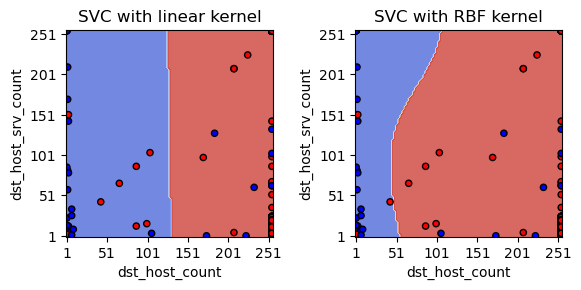

In [32]:
import matplotlib.pyplot as plt
from sklearn import datasets, svm
from sklearn.inspection import DecisionBoundaryDisplay
from imblearn.under_sampling import RandomUnderSampler

#set up features and target data
X = kddcup99_filtered[['dst_host_count', 'dst_host_srv_count']]  # features count and srv_count
y = kddcup99_filtered['dos']  # target

subsample_ratio = 0.01
num_samples = int(len(X) * subsample_ratio)
random_indices = np.random.choice(len(X), num_samples, replace=False)
X_subsampled = X.iloc[random_indices]
y_subsampled = y.iloc[random_indices]

#visualization
models = (svm.SVC(kernel='linear'), svm.SVC(kernel='rbf'))
models = (clf.fit(X_subsampled, y_subsampled) for clf in models)
titles = ('SVC with linear kernel', 'SVC with RBF kernel')

# Set-up 1x2 grid for plotting.
fig, sub = plt.subplots(1, 2)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

X0 = X_subsampled['dst_host_count']
X1 = X_subsampled['dst_host_srv_count']

colors = ['red' if label == 1 else 'blue' for label in y_subsampled]

for clf, title, ax in zip(models, titles, sub.flatten()):
    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        X_subsampled,
        response_method="predict",
        cmap=plt.cm.coolwarm,
        alpha=0.8,
        ax=ax,
        xlabel='dst_host_count',
        ylabel='dst_host_srv_count',
    )
    ax.scatter(X0, X1, c=colors, s=20, edgecolors="k")
    ax.set_xticks(np.arange(min(X0), max(X0) + 1, 50))
    ax.set_yticks(np.arange(min(X1), max(X1) + 1, 50))
    ax.set_title(title)
    ax.set_aspect('equal')

plt.show()


In [ ]:
#I selected dst_host_count and dst_host_srv_count features for the visualization. The linear kernel model provides a good estimation but there are alot of misclassified samples. 
#In this case, RBF kernel model does a better job fitting the data and reduce the number of misclassifications. 
#Linear is most used for linearly separable data. In this problem, the data is not linearly separable. RBF should be used. 